# Overview

Clean data so that it can be used for fitting models. Fit models and interperet what they are saying. Run model diagnostics and compare models to each other on holdout set. Export cleaned data so others can use the data easily.

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

# Imports and data loading

In [1]:
# Install the interpret package 
# https://github.com/interpretml/interpret/
!pip install interpret > /dev/null

In [2]:
# Filesystem
from google.colab import drive

# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(10,5)})
%matplotlib inline

# Pipeline
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import KNNImputer

# Feature selection
from sklearn.decomposition import PCA


# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Interpret
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
set_visualize_provider(InlineProvider())


In [3]:
# Load from github

url = 'https://raw.githubusercontent.com/natelac/Great-Lakes-Fishing-Data-and-Analysis/main/data/'
fishbd = pd.read_csv(url + 'fishing_by_date.csv');

In [4]:
# Load from colab

# drive.mount('/content/drive', force_remount=True);

# path_to_folder = 'drive/My Drive/Colab Notebooks/Fishing/data/'
# fishbd = pd.read_csv(path_to_folder + 'fishing_by_date.csv');

Mounted at /content/drive


# Preparing data

## Feature selection

The `hooked`, `caught`, `fish_length`, `fish_type`, and `hours_fishing` are all at a high risk of data leakage so they are removed. `hours_fishing` seems like it might be useful, but once the fish limit is caught the fishing trip ends so it is a biased feature. They also don't make sense in the context of planning a day to go fishing since they require catching fish to obtain. The features `date`, `start_time`, `end_time`, and `time` can be removed since the important characteristics of them have already been captured in the categorical features `time_period` and `season`, and the numerical feature `year`.

From our analysis we saw that the diff metric features weren't too helpful, so we will just be using the raw metrics here.

In [8]:
# From our analysis, we saw that south west winds were very good, let's make a
# variable for "southwesterness" of the wind
df = fishbd
df['sw_wind'] = df['wind_dir'] - 225
df.sw_wind = abs(df.sw_wind)
df.sw_wind = df.sw_wind % 180
df.sw_wind = df.sw_wind / max(df.sw_wind)
df.sw_wind = 1 - df.sw_wind

In [9]:
# Select useful features

X_selected = df[['year', 'time_period', 'season', 'location', 'weather',
                 'trolling_speed', 'water_depth', 'wind_speed', 'sw_wind',
                 'gust_speed', 'pressure', 'air_temp', 'dew_point']]

# Controlled hook-rate (from data analysis)
y = df['hook_rate'] / (0.19734954495663856 * df['crew_count'] + 1.2623066665134317)

## One-hot-encoding

Since we are working with so few data points (391) we need to be careful with how we split our data. The total number of features including when one-hot-encoded is about 31. We have about 10x points for each feature which is pretty good, but still a bit low especially when we do our splits. 

Luckily for us the bulk of these categorical dimensions are from `location`. Although I don't do it here, we could reduce the low sample-size categories of `location` into a single `other` column.

Our good-enough solution (for now) is to use aggressive lasso regression to reduce the dimensionality allowing us to then increase the dimensionality with interacting terms if we choose to.

In [10]:
# Split by categorical
X_cat = X_selected.select_dtypes(include='object')
X_cont = X_selected.select_dtypes(exclude='object')

# Create one-hot-encoder
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_cat)

# Apply one-hot-encoding
X_cat = pd.DataFrame(ohe.transform(X_cat).toarray())

# Get new categorical feature names
cat_names = X_selected.select_dtypes(include='object').columns 
transformed_cat_names = ohe.get_feature_names_out(list(cat_names))
X_cat.columns = transformed_cat_names

# Combine categorical and continuous features
X_encoded = X_cont.join(X_cat)

## Handling nans

In [11]:
X_cont.isna().sum()

year                0
trolling_speed      0
water_depth         0
wind_speed          6
sw_wind             6
gust_speed          6
pressure            5
air_temp            5
dew_point         195
dtype: int64

In [12]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")
X_cleaned = imputer.fit_transform(X_encoded)
X_cleaned = pd.DataFrame(X_cleaned)
X_cleaned.columns = X_encoded.columns

## Splitting data

Since we have so few data-points we need to be careful. We will create a holdout dataset containing 20% of our data. The remaining 80% will be split into a training and validation set so that we can use cross-validation to train our models and perform hyper-parameter tuning

In [13]:
# Set aside holdout set
X_reduced, X_holdout, y_reduced, y_holdout = train_test_split(
    X_cleaned, y, test_size=0.2, random_state=49)

# Split the non-holdout data into a training and testing split
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_reduced, test_size=0.2, random_state=50)

# Predicting `hook_rate`

## Helper functions

In [14]:
# Score model using mean_squared_error and r2_score
def score_model(model, X=X_holdout, y=y_holdout, name="Model X"):

    # Model prediction
    y_pred = model.predict(X)

    # Compute metrics
    mse = mean_squared_error(y_holdout, y_pred)
    r2 = r2_score(y_holdout, y_pred)

    # Print results
    print(f"Scoring {name}")
    print(f"\tMSE: {round(mse,3)}")
    print(f"\tr2_score: {round(r2,3)}")

## Lasso

The lasso model is excellent for figuring out what features are important. Even in very high dimensional data it is able to perform well without overfitting. 

The first model is scaled by centering the data around the mean only. In turn, the coefficients can be interpreted as how much the hook-rate will change with a change in a given feature. 

The other models are scaled with unit variance. This means the coefficients cannot be interpreted literally, however they can be interpreted relative to each other by magnitude. Be careful when interpereting coefficients that are significantly smaller (in magnitude) than the larger coefficients.



### Helper functions

In [15]:
# Fit and return lasso model and also create plots for it
def lasso_fitplot(X, y, title="", min_exp=-3, max_exp=0, tol=1e-4,
                  plot_coef_limit=0):

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)

    # Fit lasso model
    param_range=np.logspace(min_exp, max_exp, 20)
    train_scores, test_scores = validation_curve(
        Lasso(tol=tol), X, y, param_name='alpha',
        param_range=param_range, cv=10)

    # Plot training and validation curves
    test_scores_mean = np.mean(test_scores, axis=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    ax1.semilogx(param_range, train_scores_mean, label="Training score")
    ax1.semilogx(param_range, test_scores_mean, label="Cross-validation score")
    ax1.legend();
    ax1.set_ylabel("Score")
    ax1.set_xlabel(r"$\alpha$")
    ax1.set_ylim(-0.05, 0.5)

    # Fit best model
    alpha = param_range[np.argmax(test_scores_mean)]
    lasso = Lasso(alpha=alpha, tol=tol).fit(X, y)

    # Sort columns and coefficients by coefficient
    coefs = pd.DataFrame({"feature": X.columns,
                          "coef": lasso.coef_})
    coefs = coefs.sort_values(by="coef").reset_index(drop=True)
    
    # Plot coefficients
    mask = coefs.coef.apply(lambda x: abs(x)) > plot_coef_limit
    sns.barplot(y=coefs.loc[mask, 'feature'], x=coefs.loc[mask, 'coef'], ax=ax2,
                orient='h')
    ax2.legend([], title=f"alpha: {round(alpha, 4)}\ny-intercept: {round(lasso.intercept_, 4)}")

    plt.tight_layout()

    return lasso

### Fit with no interactions

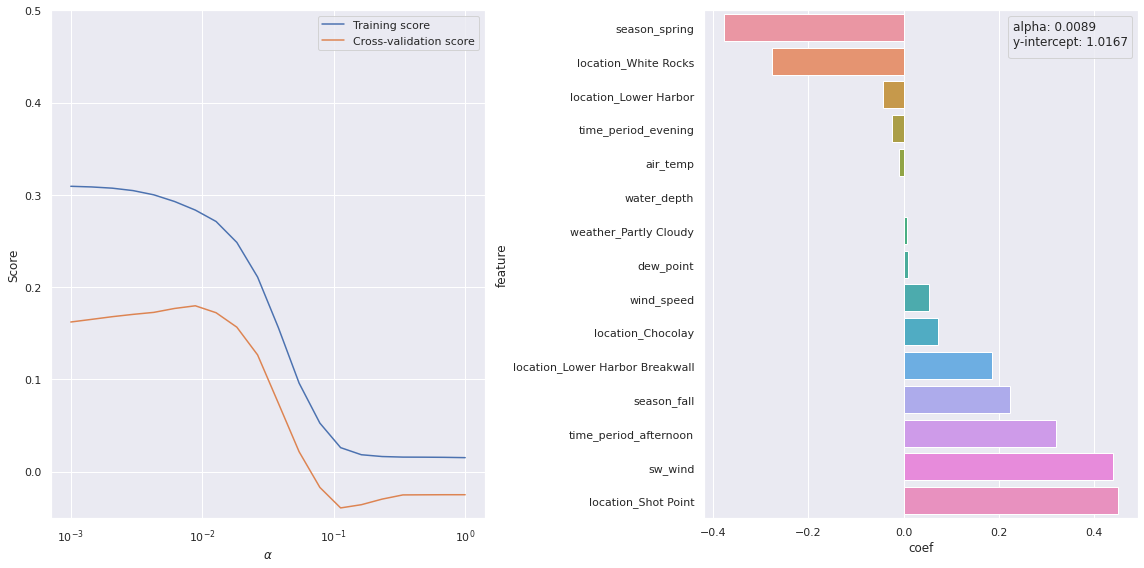

In [16]:
# Scale data without std
scaler1 = StandardScaler(with_std=False)
X_scaled1 = pd.DataFrame(scaler1.fit_transform(X_reduced))
X_scaled1.columns = X_reduced.columns

# fit and plot lasso model
lasso1 = lasso_fitplot(X_scaled1, y_reduced)

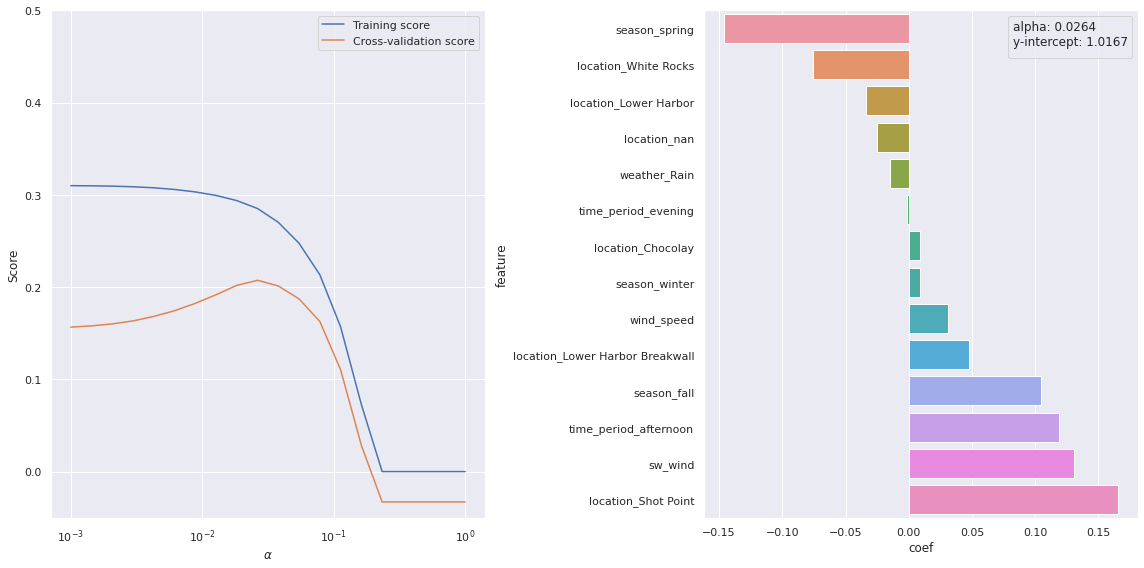

In [17]:
# Scale data with variance
scaler2 = StandardScaler()
X_scaled2 = pd.DataFrame(scaler2.fit_transform(X_reduced))
X_scaled2.columns = X_reduced.columns

# fit and plot lasso model
lasso2 = lasso_fitplot(X_scaled2, y_reduced)

### Fit with interactions

In [18]:
# Create interaction terms
poly = PolynomialFeatures(interaction_only=True, include_bias = False)
X_interactions = poly.fit_transform(X_reduced)

# Scale data std
scaler3 = StandardScaler(with_std=True)
X_scaled3 = pd.DataFrame(scaler3.fit_transform(X_interactions))
X_scaled3.columns = poly.get_feature_names_out(X_reduced.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.758e-02, tolerance: 1.585e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


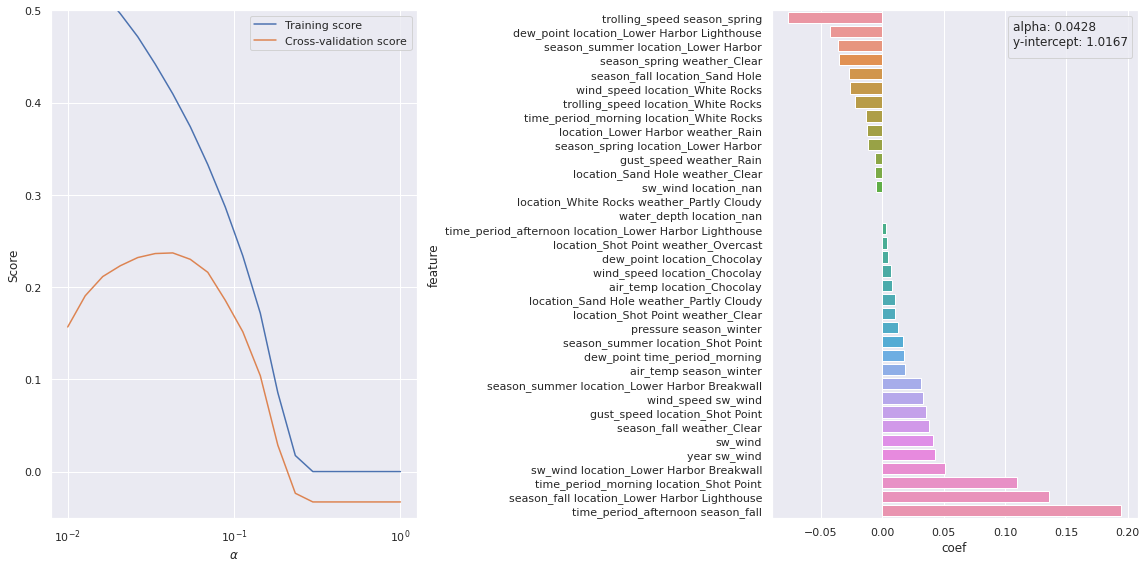

In [19]:
# Fit and plot lasso model
lasso3 = lasso_fitplot(X_scaled3, y_reduced, min_exp=-2)

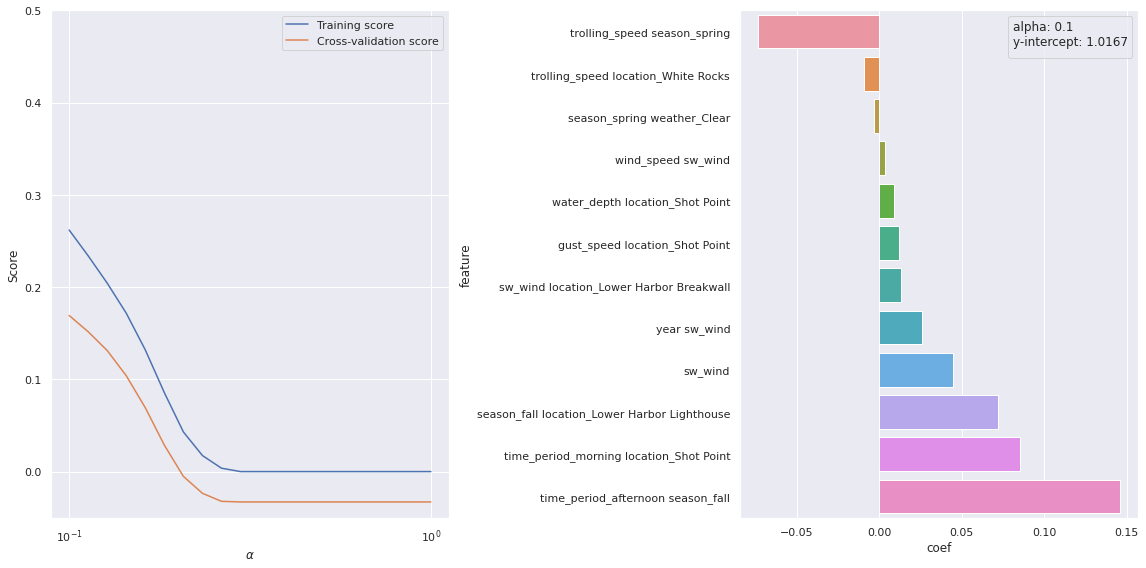

In [20]:
# More aggressive regularization
lasso4 = lasso_fitplot(X_scaled3, y_reduced, min_exp=-1)

### Model diagnostics

***WARNING***

*Run this section sparingly, do not use it to inform changes to your models in any way.*

The models with interaction terms are showing some signs of overfitting. They are selecting some intreaction terms that don't make sense to be relevant, they are selecting too many features, and they are getting worse $R^2$ scores than the non-interaction models.

In [21]:
# MSE on holdout set

# No interaction scaled without std
X_trans = pd.DataFrame(scaler1.transform(X_holdout))
X_trans.columns = X_holdout.columns
score_model(lasso1, X_trans, name="No scale on std")

# No interactions scaled with std
X_trans = pd.DataFrame(scaler2.transform(X_holdout))
X_trans.columns = X_holdout.columns
score_model(lasso2, X_trans, name="Scaled on std")

# Interactions best
X_trans = poly.fit_transform(X_holdout)
X_trans = pd.DataFrame(scaler3.transform(X_trans))
X_trans.columns = poly.get_feature_names_out(X_holdout.columns)
score_model(lasso3, X_trans, name="Full interactions")

# Interactions heavily-pruned
score_model(lasso4, X_trans, name="Pruned interactions")

Scoring No scale on std
	MSE: 0.363
	r2_score: 0.199
Scoring Scaled on std
	MSE: 0.366
	r2_score: 0.193
Scoring Full interactions
	MSE: 0.381
	r2_score: 0.161
Scoring Pruned interactions
	MSE: 0.368
	r2_score: 0.188


## Explainable Boosting Regressor

One of my goals with this notebook is to create interpretable models. [`interpret`](https://interpret.ml/docs/ebm.html) is a python library created by Microsoft. It's goal is to create glassbox machine learning methods that have structure and performance comparable to blackbox methods like XGBoost and Random Forest. Check out their paper for a more detailed explanation.

*The project is in beta and is a bit buggy, the biggest bug I've been running into is that it doesn't always display the diagnostic plots which are the main attractor for the package. If this happens to you, restart the runtime and run the code again. It will only display one plot, so comment out the chunks for the models you don't want to see and keep the ones you do.*

### Fit EBM model

In [22]:
# Create and show the EBM
seed = 1

ebm1 = ExplainableBoostingRegressor(random_state=seed)
ebm1.fit(X_reduced, y_reduced)

ebm_global = ebm1.explain_global()
show(ebm_global)

ebm_local = ebm1.explain_local(X_test[:5], pd.DataFrame(y_test[:5]))
show(ebm_local)

Output hidden; open in https://colab.research.google.com to view.

### Fit EBM model using lasso selected terms

In [23]:
# Create and show the EBM
seed = 1

ebm2 = ExplainableBoostingRegressor(random_state=seed)
ebm2.fit(X_reduced.loc[:, abs(lasso1.coef_) > 0], pd.DataFrame(y_reduced))

ebm_global = ebm2.explain_global()
show(ebm_global)

ebm_local = ebm2.explain_local(X_test.loc[:,abs(lasso1.coef_) > 0][:5], pd.DataFrame(y_test[:5]))
show(ebm_local)

### Model diagnostics

***WARNING***

*Run this section sparingly, do not use it to inform changes to your models in any way.*

These models performed better than I expected! It does appear to suffer from some overfitting, but using the coefficients selected by lasso helped reduce that. What is cool about the EBM models is that the plots for each feature are exactly what the model uses when it's predicting values.

I ran a version of this notebook with `wind_dir` and `sw_wind` and thie EBM1 model performed incredibly well with a $R^2$ of 0.225. I'm not sure what to make of that, maybe it is really able to pick up how wind direction interacts with location? I chocked it up to overfitting to the dataset as a whole, but it something I might want to investigate later.

In [24]:
# MSE on holdout set
if 'ebm1' in locals():
    score_model(ebm1, X_holdout, name="EBM1")

if 'ebm2' in locals():
    score_model(ebm2, X_holdout.loc[:,abs(lasso1.coef_) > 0], name="EBM2")

Scoring EBM1
	MSE: 0.377
	r2_score: 0.17
Scoring EBM2
	MSE: 0.396
	r2_score: 0.128
